In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from model_settings import ms
from df_collector import df_collector
pd.set_option("display.max_columns",0)
pd.options.display.float_format = '{:.6f}'.format
root = Path().resolve().parent.parent
df_collector.root = root
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}")


##################
# training start #
##################

Fri Nov  8 17:48:05 2024


# loading data

In [2]:
data = df_collector.cboe_spx_barriers().iloc[:,1:]
pricename = [f for f in data.columns if f.find('_price')!=-1 and f.find('spot_')==-1 and f.find('strike_')==-1][0]
relative_pricename = 'relative_'+pricename
data = data[data[pricename]<=data['spot_price']]
print(f'collected {pricename[:pricename.find('_',0)]} options')
print(data.describe())
print(data.dtypes)
print(data['calculation_date'].drop_duplicates())

collected barrier options
          spot_price   strike_price        barrier  days_to_maturity         rebate  dividend_rate  risk_free_rate          theta          kappa            rho            eta             v0  barrier_price
count 2037988.000000 2037988.000000 2037988.000000    2037988.000000 2037988.000000 2037988.000000  2037988.000000 2037988.000000 2037988.000000 2037988.000000 2037988.000000 2037988.000000 2037988.000000
mean     3771.972490    3771.988511    3785.619135        323.112634       0.000000       0.016717        0.023852       0.127303       5.861038      -0.795742       2.001972       0.060612     177.360437
std       844.635317     880.736463    1459.605277        240.806413       0.000000       0.002448        0.018788       0.186416       9.132415       0.162223       2.112885       0.090671     328.070614
min      2389.000000    2150.100000    1194.500000         60.000000       0.000000       0.012624        0.000330       0.000000       0.000000      -1.0

In [3]:
filetag = f'cboe spx relative {pricename[:pricename.find('_',0)]}'

In [4]:
data[pricename].describe()

count   2037988.000000
mean        177.360437
std         328.070614
min           0.000000
25%           1.635566
50%          50.164341
75%         225.734882
max        5424.825644
Name: barrier_price, dtype: float64

# data cleaning & preparation

In [5]:
data_strikes = data['strike_price']
data['relative_spot'] = data['spot_price']/data_strikes
data[relative_pricename] = data[pricename]/data_strikes
try:
    data['relative_barrier'] = data['barrier']/data_strikes
    data['relative_rebate'] = data['rebate']/data_strikes
except Exception:
    pass

data['calculation_date'] = pd.to_datetime(data['calculation_date'],format='mixed')
data['date'] = pd.to_datetime(data['date'],format='mixed')
data.dtypes

spot_price                       float64
strike_price                     float64
barrier                          float64
days_to_maturity                   int64
updown                            object
outin                             object
w                                 object
barrier_type_name                 object
rebate                           float64
dividend_rate                    float64
risk_free_rate                   float64
theta                            float64
kappa                            float64
rho                              float64
eta                              float64
v0                               float64
calculation_date          datetime64[ns]
date                      datetime64[ns]
barrier_price                    float64
relative_spot                    float64
relative_barrier_price           float64
relative_barrier                 float64
relative_rebate                  float64
dtype: object

In [6]:
def noisify(x):
    return x + np.random.normal(scale=x*0.01)

relative_observed = data[relative_pricename].values
relative_observed[relative_observed>0] = noisify(relative_observed[relative_observed>0])
targetname = 'relative_observed'
data[targetname]= relative_observed
data[targetname].describe()

count   2037988.000000
mean          0.048599
std           0.090974
min           0.000000
25%           0.000452
50%           0.013576
75%           0.061705
max           1.073617
Name: relative_observed, dtype: float64

# visualization

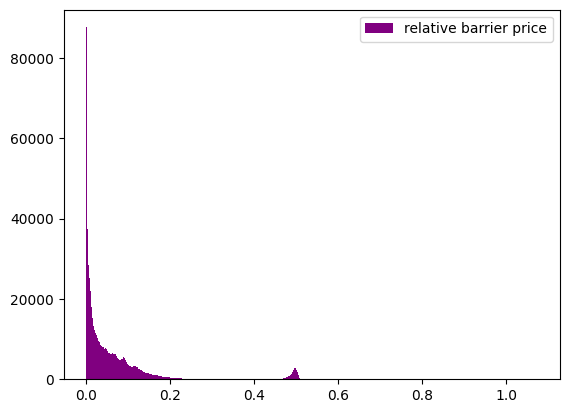

count   1521171.000000
mean          0.065089
std           0.100079
min           0.000500
25%           0.008640
50%           0.032352
75%           0.081031
max           1.073617
Name: relative_observed, dtype: float64

In [7]:
"""
plot
"""
rels = data[targetname]
rels = rels[rels>0.0005]
plt.figure()
plt.hist(rels,color='purple',label=relative_pricename.replace('_',' '),bins=int(np.sqrt(len(rels))))
plt.legend()
plt.show()
rels.describe()

['spot_price', 'kappa', 'theta', 'rho', 'eta', 'v0', 'risk_free_rate', 'dividend_rate', 'relative_barrier_price', 'spot_price']


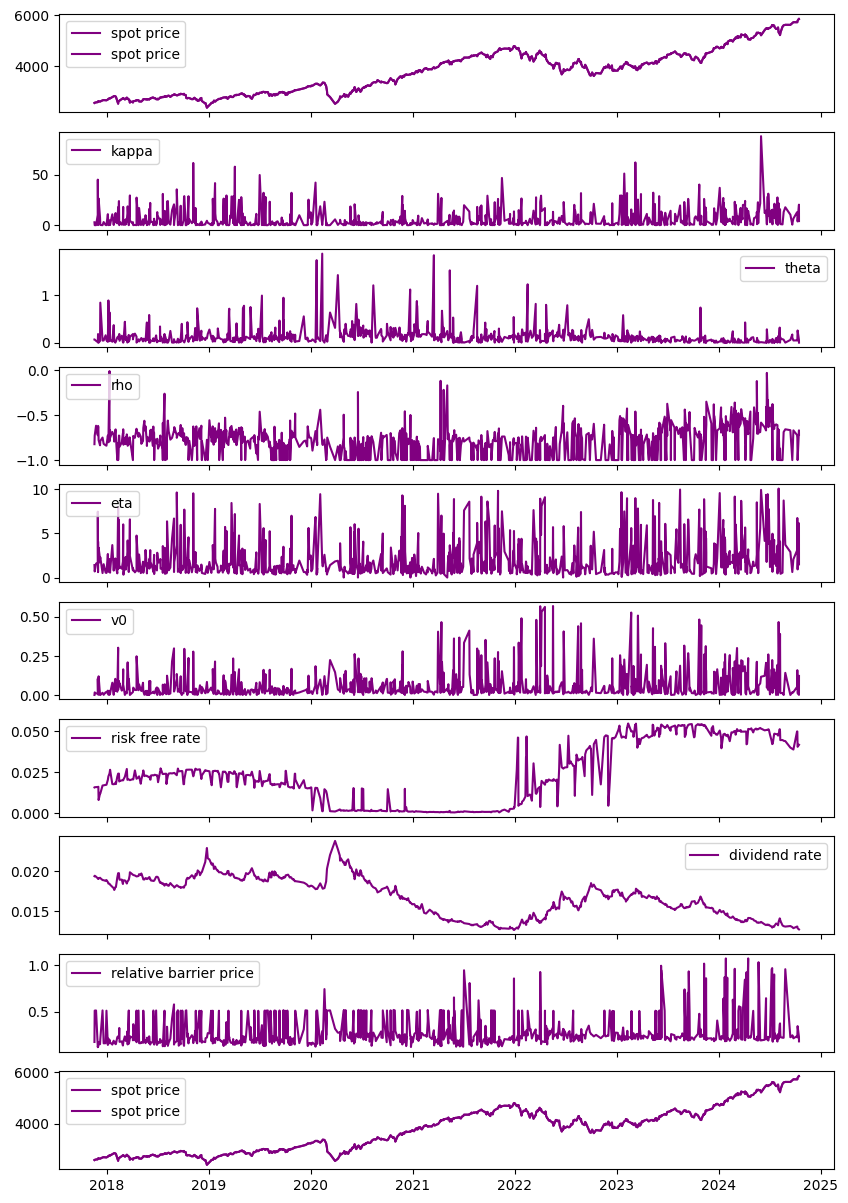

where 'relative_barrier_price' is the maximum market observed relative barrier option price


count   2037988.000000
mean          0.048599
std           0.090974
min           0.000000
25%           0.000452
50%           0.013576
75%           0.061705
max           1.073617
Name: relative_barrier_price, dtype: float64

In [8]:
from plotters import PlotCols
col_names = ['spot_price','kappa','theta','rho','eta','v0','risk_free_rate','dividend_rate',relative_pricename,'spot_price']
index = 'calculation_date'
plot_data = data[col_names+[index]].copy().sort_values(by=relative_pricename).drop_duplicates(subset=index,keep='last').sort_values(by=index).reset_index(drop=True)
data_cols = [index] + col_names
PlotCols(
    plot_data,
    col_names=col_names,
    index=index,
    figsize=(10,15)
)
print(f"where '{relative_pricename}' is the maximum market observed relative {pricename[:pricename.find('_',0)]} option price")
pd.Series(plot_data[index])
data[relative_pricename].describe()

# training procedure

## model parameterization and initializaiton

In [9]:
from convsklearn import convsklearn
trainer = convsklearn()
trainer.target_name = relative_pricename
trainer.excluded_features = trainer.excluded_features + ['spot_price','strike_price','barrier','rebate',relative_pricename,'relative_observed']
trainer.__dict__

{'seed': 1312,
 'raw_data': Empty DataFrame
 Columns: []
 Index: [],
 'dataset': Empty DataFrame
 Columns: []
 Index: [],
 'target_name': 'relative_barrier_price',
 'excluded_features': ['barrier_price',
  'asian_price',
  'observed_price',
  'outin',
  'updown',
  'n_fixings',
  'spot_price',
  'strike_price',
  'barrier',
  'rebate',
  'relative_barrier_price',
  'relative_observed'],
 'numerical_features': [],
 'categorical_features': [],
 'feature_set': [],
 'n_features': 0,
 'development_dates': {},
 'test_dates': {},
 'train_data': {},
 'test_data': {},
 'train_X': {},
 'train_y': {},
 'test_X': {},
 'test_y': {},
 'preprocessor': None,
 'pipeline': None,
 'model': None,
 'model_fit': None,
 'dnn_runtime': 0,
 'numerical_scaler': StandardScaler()}

In [10]:
trainer.load_data(data)
print('features:')
for f in trainer.feature_set:
    print(f"   {f}")
print(f"\ntarget:\n   {trainer.target_name}")

features:
   days_to_maturity
   dividend_rate
   risk_free_rate
   theta
   kappa
   rho
   eta
   v0
   relative_spot
   relative_barrier
   relative_rebate
   w
   barrier_type_name

target:
   relative_barrier_price


In [11]:
dates = data['date'].drop_duplicates()

## prepocessing

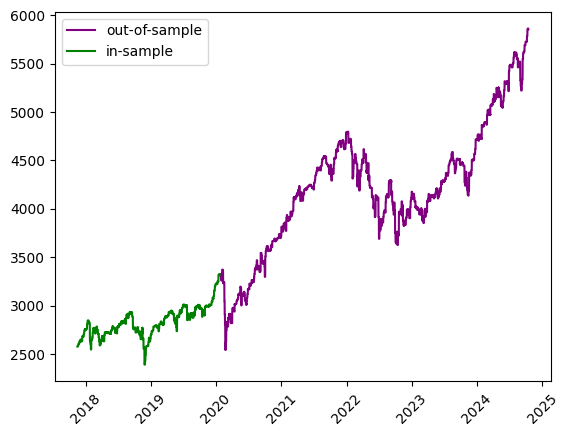

In [12]:
development_dates = dates[:len(dates)//3]
test_dates = dates[~dates.isin(development_dates)]
trainer.preprocess_data(development_dates,test_dates)

## training

In [13]:
trainer.run_dnn()


training on 650860 samples...

alpha: 0.01
hidden_layer_sizes: (13, 13)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
random_state: 1312
cpu: 163.63143968582153


In [14]:
print('instance variables:')

for key, value in trainer.__dict__.items():
    print(f"{key}:\n  {value}\n")

instance variables:
seed:
  1312

raw_data:
           spot_price  strike_price     barrier  days_to_maturity updown outin     w  ...       date  barrier_price  relative_spot  relative_barrier_price  relative_barrier  relative_rebate  relative_observed
0       2576.000000   2318.400000 1288.000000                60   Down   Out  call  ... 2017-11-16     261.916242       1.111111                0.113760          0.555556         0.000000           0.113760
1       2576.000000   2318.400000 1288.000000                60   Down   Out   put  ... 2017-11-16       6.430122       1.111111                0.002800          0.555556         0.000000           0.002800
2       2576.000000   2318.400000 1288.000000                60   Down    In  call  ... 2017-11-16       0.000000       1.111111                0.000000          0.555556         0.000000           0.000000
3       2576.000000   2318.400000 1288.000000                60   Down    In   put  ... 2017-11-16       0.000000       1.1111

## testing

In [15]:
train_test = trainer.test_prediction_accuracy()


in sample:
     RMSE: 0.021575797317663934
     MAE: 0.010853557037405016

out of sample:
     RMSE: 0.1617864252065067
     MAE: 0.07226816187077142


In [16]:
oserr = trainer.test_data['outofsample_error']
iserr = trainer.train_data['insample_error']

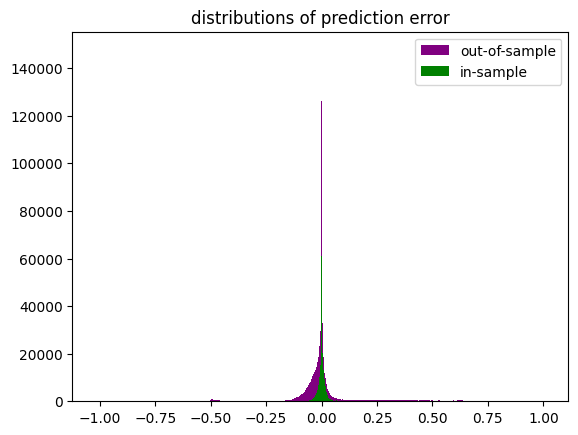

In [17]:
plt.figure()
plt.hist(oserr,color='purple',label='out-of-sample',bins=int(np.sqrt(len(oserr))))
plt.hist(iserr,color='green',label='in-sample',bins=int(np.sqrt(len(iserr))))
plt.legend()
plt.title('distributions of prediction error')
plt.show()

## saving

In [18]:
train_end = time.time()
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H%M%S%f"))
file_tag = str(train_end_tag + " " + filetag)
files_dir = os.path.join(models_dir,file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    joblib.dump(trainer.__dict__,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")

execute the command 'save_model()' to save the following model: 2024_11_08 175101227443 cboe spx relative barrier

cpu: 175.51972007751465
